# GROUP 16: MARKET BASKET ANALYSIS

In [26]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import random
import itertools
import powerlaw
import community as community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from apyori import apriori
from mlxtend.frequent_patterns import apriori,association_rules
from scipy.stats import poisson
from pandas.plotting import parallel_coordinates

In [27]:
#pip install apyori
#pip install powerlaw
#pip install mlxtend==0.23.1

In [28]:
orders_prior = pd.read_csv('order_products__prior.csv')
orders_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [29]:
orders_train = pd.read_csv('order_products__train.csv')
orders_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [30]:
products = pd.read_csv('products.csv')
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [31]:
full_order_prior = pd.merge(orders_prior, products, on='product_id', how='inner')
full_order_prior

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16
...,...,...,...,...,...,...,...
32434484,3265099,43492,3,0,Gourmet Burger Seasoning,104,13
32434485,3361945,43492,19,0,Gourmet Burger Seasoning,104,13
32434486,3267201,33097,2,0,Piquillo & Jalapeno Bruschetta,81,15
32434487,3393151,38977,32,0,Original Jerky,100,21


In [32]:
full_order_train = pd.merge(orders_train, products, on='product_id', how='inner')
full_order_train

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16
...,...,...,...,...,...,...,...
1384612,3420011,1528,12,0,Sprinkles Decors,97,13
1384613,3420084,47935,20,0,Classic Original Lip Balm SPF 12,73,11
1384614,3420084,9491,21,0,Goats Milk & Chai Soap,25,11
1384615,3420088,16380,12,0,Stevia Sweetener,97,13


In [33]:
print("Number of orders:", full_order_prior.order_id.nunique())
print("Number of products:", full_order_prior.product_id.nunique())
print("Number of departments:", full_order_prior.department_id.nunique())
print("Number of aisles:", full_order_prior.aisle_id.nunique())

Number of orders: 3214874
Number of products: 49677
Number of departments: 21
Number of aisles: 134


In [34]:
order_sizes = full_order_prior['order_id'].value_counts().reset_index()
print("Maximum number of items in an order:", int(order_sizes['count'].max()))
print("Average number of items in an order:", int(order_sizes['count'].mean()))

Maximum number of items in an order: 145
Average number of items in an order: 10


In [35]:
full_order_prior = pd.merge(full_order_prior, order_sizes, on='order_id')

## Make Weighted Graph

In [36]:
# graph with department_id and aisle_id attributes 
g = nx.Graph()

for order_id, group in full_order_prior.groupby('order_id'):
    products = group['product_name'].tolist()
    
    for _, row in group.iterrows():
        product = row['product_name']
        aisle_id = row['aisle_id']
        department_number = row['department_id']
        
        if not g.has_node(product):
            g.add_node(product, aisle_id=aisle_id, department_number=department_number)
    
    for product1, product2 in itertools.combinations(products, 2):
        if g.has_edge(product1, product2):
            g[product1][product2]['weight'] += 1
        else:
            g.add_edge(product1, product2, weight=1)



In [37]:
print("Number of edges:", g.number_of_edges())
print("Number of nodes:", g.number_of_nodes())
print("Average degree:", (2 * g.number_of_edges())/g.number_of_nodes())
total_weight = sum(data['weight'] for _, _, data in g.edges(data=True))
print("Average weight:",  total_weight / g.number_of_edges())

Number of edges: 40749010
Number of nodes: 49677
Average degree: 1640.5584073112304
Average weight: 5.851145291627944


In [38]:
weights = pd.Series([data['weight'] for _, _, data in g.edges(data=True)])

max_weight = weights.max()
max_weight

62341

In [39]:
weights.describe()

count   40749010.000
mean           5.851
std           66.981
min            1.000
25%            1.000
50%            1.000
75%            3.000
max        62341.000
dtype: float64

## PRUNING

In [40]:
for i in range(5, 20):
    observed_co_purchases = i
    lambda_rate = weights.mean()  

    poisson_pmf = poisson.pmf(observed_co_purchases, lambda_rate)

    
    p_value = 1 - poisson.cdf(observed_co_purchases - 1, lambda_rate)

    print(f"Poisson PMF for X = {observed_co_purchases} with λ = {lambda_rate}: {poisson_pmf:.4f}")
    print(f"P-value for X ≥ {observed_co_purchases}: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: The co-purchase frequency is significantly higher than expected by chance.")
    else:
        print("Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.")


Poisson PMF for X = 5 with λ = 5.851145291627944: 0.1644
P-value for X ≥ 5: 0.6945
Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.
Poisson PMF for X = 6 with λ = 5.851145291627944: 0.1603
P-value for X ≥ 6: 0.5301
Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.
Poisson PMF for X = 7 with λ = 5.851145291627944: 0.1340
P-value for X ≥ 7: 0.3698
Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.
Poisson PMF for X = 8 with λ = 5.851145291627944: 0.0980
P-value for X ≥ 8: 0.2358
Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.
Poisson PMF for X = 9 with λ = 5.851145291627944: 0.0637
P-value for X ≥ 9: 0.1378
Fail to reject the null hypothesis: The co-purchase frequency could be due to random chance.
Poisson PMF for X = 10 with λ = 5.851145291627944: 0.0373
P-value for X ≥ 10: 0.0741
Fail to reject the null hypothesis:

Given our large dataset, we decided to perform statistical hypothesis testing to determine whether an edge with a given weight is likely due to random chance or represents a real association. Since Poisson distribution is often used to model the number of events occurring within a fixed interval of time or space (in this case is the number of co-purchases between two products) we used this model to assess the significance of the observed number of times two products were purchased together. Here the poisson rate (lambda) represents the average number of co-purchases between all pairs of products in the network. To test the null hypothesis that the observed co-purchase frequency between two products is the result of random chance, we calculated the Poisson probability mass function for the observed value of x co-purchases, given lambda and then computed the p-value to find the cumulative probability for all values less than x before subtracting this value from 1 to get the upper-tail probability. We compared the resulting p-value to our significance level of alpha = 0.05 to decide whether we reject the null hypothesis that x number of co-purchases between two products is the result of random chance and repeated this process for every integer value of x from 5 to 20. The resulting threshold determined by this significant test is r = 11.

Although the Poisson distribution is commonly used to model the number of events occurring within a fixed interval of time or space, there may be a flaw in this approach. The Poisson distribution assumes that events occur independently and the rate (lambda) is assumed constant across all product pairs. Given the nature of our dataset, we cannot safely assume that either of these are true. The co-purchase of one pair of products could influence the co-purchase of another pair, especially since each customer has multiple orders in this network. Additionally, as we examine out highly right skewed distribution of edge weights, we cannot assume all pairs of products are equally likely to be co-purchased. 

Calculating best minimal value for power law fit
Power-law exponent (alpha): 2.3173148531646177


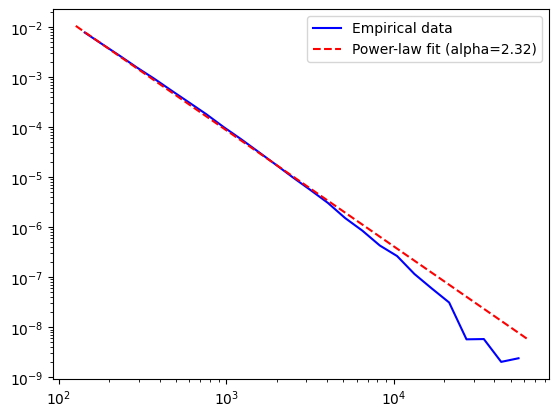

In [41]:
fit = powerlaw.Fit(weights.tolist())
alpha = fit.alpha
print("Power-law exponent (alpha):", alpha)

fit.plot_pdf(color='b', linestyle='-', label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power-law fit (alpha={alpha:.2f})')
plt.legend()
plt.show()

The graph above seems to confirm what we suspected about this network: the weights exhibit a power law distribution. We will proceed to calculate the p-value for each observed co-purchase count $k_{obs}$ in this network by comparing the observed count against the expected distribution of counts under the power-law model. Now that we have fit a power-law fitting method to estimate the scaling parameter $\alpha$ and the minimum threshold 
$k_{min}$ using our data and the powerlaw library powerlaw, we will calulate the cumulative distribution function (CDF) to determine the probability of observing a value less than or equal to $k_{obs}$ using the equation $CDF = P(k_{obs}) = 1 - (\frac{k_{min}}{k_{obs}})^{\alpha - 1}$. We will then calculate the p-value for each $k_{obs}$ which is the probability of observing $k_{obs}$ or greater under the fitted law distribution or $p-value = 1 - CDF(k_{obs}) = (\frac{k_{min}}{k_{obs}})^{\alpha - 1}$. Finally, we will compare the corresponding p-value of every unique edge weight to our aplha level of 0.05 to decide whether the edge weight is significant or not. We will accumulate all significant edge weights in the list and smallest "significant weight" serve as our threshold


In [42]:
alpha = fit.alpha  
xmin = fit.xmin    

print(f"Fitted alpha (scaling parameter): {alpha}")
print(f"Fitted xmin (minimum threshold): {xmin}")

alpha_significance = 0.05

significant_edges = []

for k_obs in weights.drop_duplicates():
    if k_obs >= xmin:  
        p_value = (xmin / k_obs) ** (alpha - 1) 
        
    if p_value < alpha_significance:
        significant_edges.append((k_obs))
min(significant_edges)

Fitted alpha (scaling parameter): 2.3173148531646177
Fitted xmin (minimum threshold): 126.0


15

Now that we have determined a threshold, we can evaluate this parameter and its effectiveness by comparing network metrics like density, centrality, and modularity before and after implementing our threshold to assess whether removing low-weight edges leads to more meaningful results. and visually inspecting the network before and after thresholding to understand how much the structure changes.


## IMPLEMENT THRESHOLD

In [43]:
# Poison threshold
threshold = 11

filtered_pois_g = nx.Graph()

# Remove edges below set threshold
for u, v, data in g.edges(data=True):
    if data['weight'] >= threshold:
        filtered_pois_g.add_edge(u, v, weight=data['weight'])

In [44]:
# Power law threshold
threshold = 15

filtered_pow_g = nx.Graph()

# Remove edges below set threshold
for u, v, data in g.edges(data=True):
    if data['weight'] >= threshold:
        filtered_pow_g.add_edge(u, v,  **data)

# Transfer all node attributes from G1 to G2
for node in g.nodes:
    if node in filtered_pow_g.nodes:
        
        filtered_pow_g.nodes[node].update(g.nodes[node])


In [45]:

print("Density")
print(f"     Original Graph Density: {nx.density(g)}")
print(f"     Filtered Graph Density: {nx.density(filtered_pois_g)}")
print(f"     Filtered Graph Density: {nx.density(filtered_pow_g)}")
# low density after threshold -> many edges were removed and the graph is sparse
# high density after threshold -> may indicate that the threshold is not high enough to prune edges meaningfully

Density
     Original Graph Density: 0.03302517125596325
     Filtered Graph Density: 0.008358857277217068
     Filtered Graph Density: 0.007813688318542284


In [46]:
print("Connected Components")
print(f"     Original Graph Connected Components: {nx.number_connected_components(g)}")
print(f"     Filtered Graph Connected Components: {nx.number_connected_components(filtered_pois_g)}")
print(f"     Filtered Graph Connected Components: {nx.number_connected_components(filtered_pow_g)}")
# dramatic increase in connected components after threshold -> threshold may be too high and is disconnecting parts of the network
# ideally want the graph to remain sufficiently connected while filtering out weak connections.

Connected Components
     Original Graph Connected Components: 4
     Filtered Graph Connected Components: 64
     Filtered Graph Connected Components: 52


In [47]:
print("Number of edges:", g.number_of_edges())
print("Number of nodes:", g.number_of_nodes())
print("Average degree:", (2 * g.number_of_edges())/g.number_of_nodes())
total_weight = sum(data['weight'] for _, _, data in g.edges(data=True))
print("Average weight:",  total_weight / g.number_of_edges())

Number of edges: 40749010
Number of nodes: 49677
Average degree: 1640.5584073112304
Average weight: 5.851145291627944


In [48]:
print("Number of edges:", filtered_pois_g.number_of_edges())
print("Number of nodes:", filtered_pois_g.number_of_nodes())
print("Average degree:", (2 * filtered_pois_g.number_of_edges())/filtered_pois_g.number_of_nodes())
total_weight = sum(data['weight'] for _, _, data in filtered_pois_g.edges(data=True))
print("Average weight:",  total_weight / filtered_pois_g.number_of_edges())

Number of edges: 3152997
Number of nodes: 27467
Average degree: 229.584373976044
Average weight: 50.372028263902564


In [49]:
print("Number of edges:", filtered_pow_g.number_of_edges())
print("Number of nodes:", filtered_pow_g.number_of_nodes())
print("Average degree:", (2 * filtered_pow_g.number_of_edges())/filtered_pow_g.number_of_nodes())
total_weight = sum(data['weight'] for _, _, data in filtered_pow_g.edges(data=True))
print("Average weight:",  total_weight / filtered_pow_g.number_of_edges())

Number of edges: 2250436
Number of nodes: 24001
Average degree: 187.5285196450148
Average weight: 65.63956362233807


In [50]:
(weights >=15).mean()

0.05522676501834032

## FEATURE ANALYSIS

In [51]:
aisle_key = pd.read_csv('aisles.csv')
dep_key = pd.read_csv('departments.csv')

In [52]:
aisle_results = []
for aisle_num in list(full_order_prior.aisle_id.drop_duplicates()):
    aisle_co_purchases = []
    for u, v, data in filtered_pow_g.edges(data=True):
        aisle_u = filtered_pow_g.nodes[u]['aisle_id']
        aisle_v = filtered_pow_g.nodes[v]['aisle_id']
        if aisle_u == aisle_v and aisle_u == aisle_num:  
            aisle_co_purchases.append((u, v, data['weight']))
    if len(aisle_co_purchases) > 1:
        aisle_co_purchases = sorted(aisle_co_purchases, key=lambda x: x[2], reverse=True)
        result = {'Aisle': aisle_num,
              'Frequency': aisle_co_purchases[0][2], 
              'Product Pair': (aisle_co_purchases[0][0], aisle_co_purchases[0][1])}
        aisle_results.append(result)
aisle_results = pd.DataFrame(aisle_results)

In [53]:
aisle_results_full = pd.merge(aisle_results, aisle_key, left_on='Aisle', right_on='aisle_id').drop(columns='Aisle')
aisle_results_full

,Frequency,Product Pair,aisle_id,aisle
0,610,"(Organic Egg Whites, Organic Grade A Free Rang...",86,eggs
1,22073,"(Organic Garlic, Organic Yellow Onion)",83,fresh vegetables
2,752,"(Garlic Powder, Onion Powder)",104,spices seasonings
3,639,"(Extra Virgin Olive Oil, Canola Oil)",19,oils vinegars
4,735,"(Cane Sugar, Light Brown Sugar)",17,baking ingredients
...,...,...,...,...
119,593,"(Sauvignon Blanc, Chardonnay)",62,white wines
120,484,"(Cabernet Sauvignon, Pinot Noir)",28,red wines
121,1037,"(Beer, India Pale Ale)",27,beers coolers
122,124,"(Vodka, Frontier Whiskey)",124,spirits


In [54]:
aisle_results_full.sort_values(by='Frequency', ascending=False).head(60)

,Frequency,Product Pair,aisle_id,aisle
8,62341,"(Organic Hass Avocado, Bag of Organic Bananas)",24,fresh fruits
1,22073,"(Organic Garlic, Organic Yellow Onion)",83,fresh vegetables
7,18044,"(Organic Baby Spinach, Organic Raspberries)",123,packaged vegetables fruits
17,13284,"(Lime Sparkling Water, Sparkling Water Grapefr...",115,water seltzer sparkling water
15,9331,(Total 2% with Strawberry Lowfat Greek Straine...,120,yogurt
22,7455,"(Organic Cilantro, Organic Italian Parsley Bunch)",16,fresh herbs
11,6763,"(Organic Whole Strawberries, Frozen Organic Wi...",116,frozen produce
14,5064,"(Raspberries, Hass Avocados)",32,packaged produce
16,3970,"(Soda, Zero Calorie Cola)",77,soft drinks
46,3373,"(Organic Black Beans, Organic Garbanzo Beans)",59,canned meals beans


In [100]:
aisle_results_full.iloc[0]['Product Pair']

('Organic Egg Whites', 'Organic Grade A Free Range Large Brown Eggs')


Interesting findings include dried mango and organic rolled oats from the bulk section; crescent rolls and cinnamon rolls with icing from the pantry department; hummus and uncured genoa salami in the deli section; hass avocado and bag of organic bananas in the produce section.


In [55]:
dep_results = []
for dep_num in list(full_order_prior.department_id.drop_duplicates()):
    dep_co_purchases = []
    for u, v, data in filtered_pow_g.edges(data=True):
        dep_u = filtered_pow_g.nodes[u]['department_number']
        dep_v = filtered_pow_g.nodes[v]['department_number']
        if dep_u == dep_v and dep_u == dep_num:  # Check if both products are in aisle 1
            dep_co_purchases.append((u, v, data['weight']))
    dep_co_purchases = sorted(dep_co_purchases, key=lambda x: x[2], reverse=True)
    result = {'Department': dep_num,
              'Frequency': dep_co_purchases[0][2], 
              'Product Pair': (dep_co_purchases[0][0], dep_co_purchases[0][1])}O
    dep_results.append(result)
dep_results = pd.DataFrame(dep_results)

In [56]:
dep_results_full = pd.merge(dep_results, dep_key, left_on='Department', right_on='department_id').drop(columns='Department')
dep_results_full

,Frequency,Product Pair,department_id,department
0,9331,(Total 2% with Strawberry Lowfat Greek Straine...,16,dairy eggs
1,62341,"(Organic Hass Avocado, Bag of Organic Bananas)",4,produce
2,983,"(Crescent Rolls, Cinnamon Rolls with Icing)",13,pantry
3,1928,"(Boneless Skinless Chicken Breasts, Ground Tur...",12,meat seafood
4,6763,"(Organic Whole Strawberries, Frozen Organic Wi...",1,frozen
5,13284,"(Lime Sparkling Water, Sparkling Water Grapefr...",7,beverages
6,2258,"(Organic Bunny Fruit Snacks Berry Patch, Organ...",19,snacks
7,830,"(with Crispy Almonds Cereal, Cherrios Honey Nut)",14,breakfast
8,2591,"(Original Hummus, Uncured Genoa Salami)",20,deli
9,989,"(Shells & Real Aged Cheddar Macaroni & Cheese,...",9,dry goods pasta


In [101]:
dep_results_full.iloc[6]['Product Pair']

('Organic Bunny Fruit Snacks Berry Patch',
 'Organic Summer Strawberry Bunny Fruit Snacks')

## MODULARITY COMMUNITY DETECTION

### Greedy

In [58]:
mod_communities = list(greedy_modularity_communities(filtered_pow_g))

for community_id, comm in enumerate(mod_communities):
    for node in comm:
        filtered_pow_g.nodes[node]['community'] = community_id
        
# report number of communities found
print("Number of communities detected:", len(mod_communities))
# report the number of nodes in the largest community
print("Number of nodes in the largest community:", len(sorted(mod_communities[0])))

Number of communities detected: 85
Number of nodes in the largest community: 13791


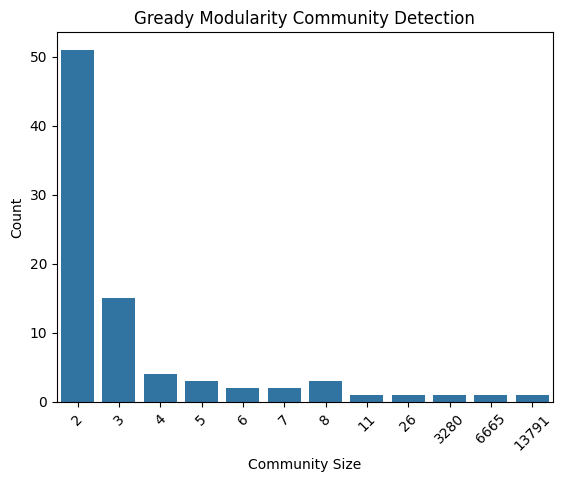

In [91]:
lengths = [len(s) for s in mod_communities]
sns.countplot(x=lengths)
plt.xlabel('Community Size')
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=10)
plt.ylabel('Count')
_ = plt.title('Gready Modularity Community Detection')

In [60]:
pd.Series(lengths).describe()

count      85.000
mean      282.365
std      1685.360
min         2.000
25%         2.000
50%         2.000
75%         3.000
max     13791.000
dtype: float64

/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_11466/3658517646.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories


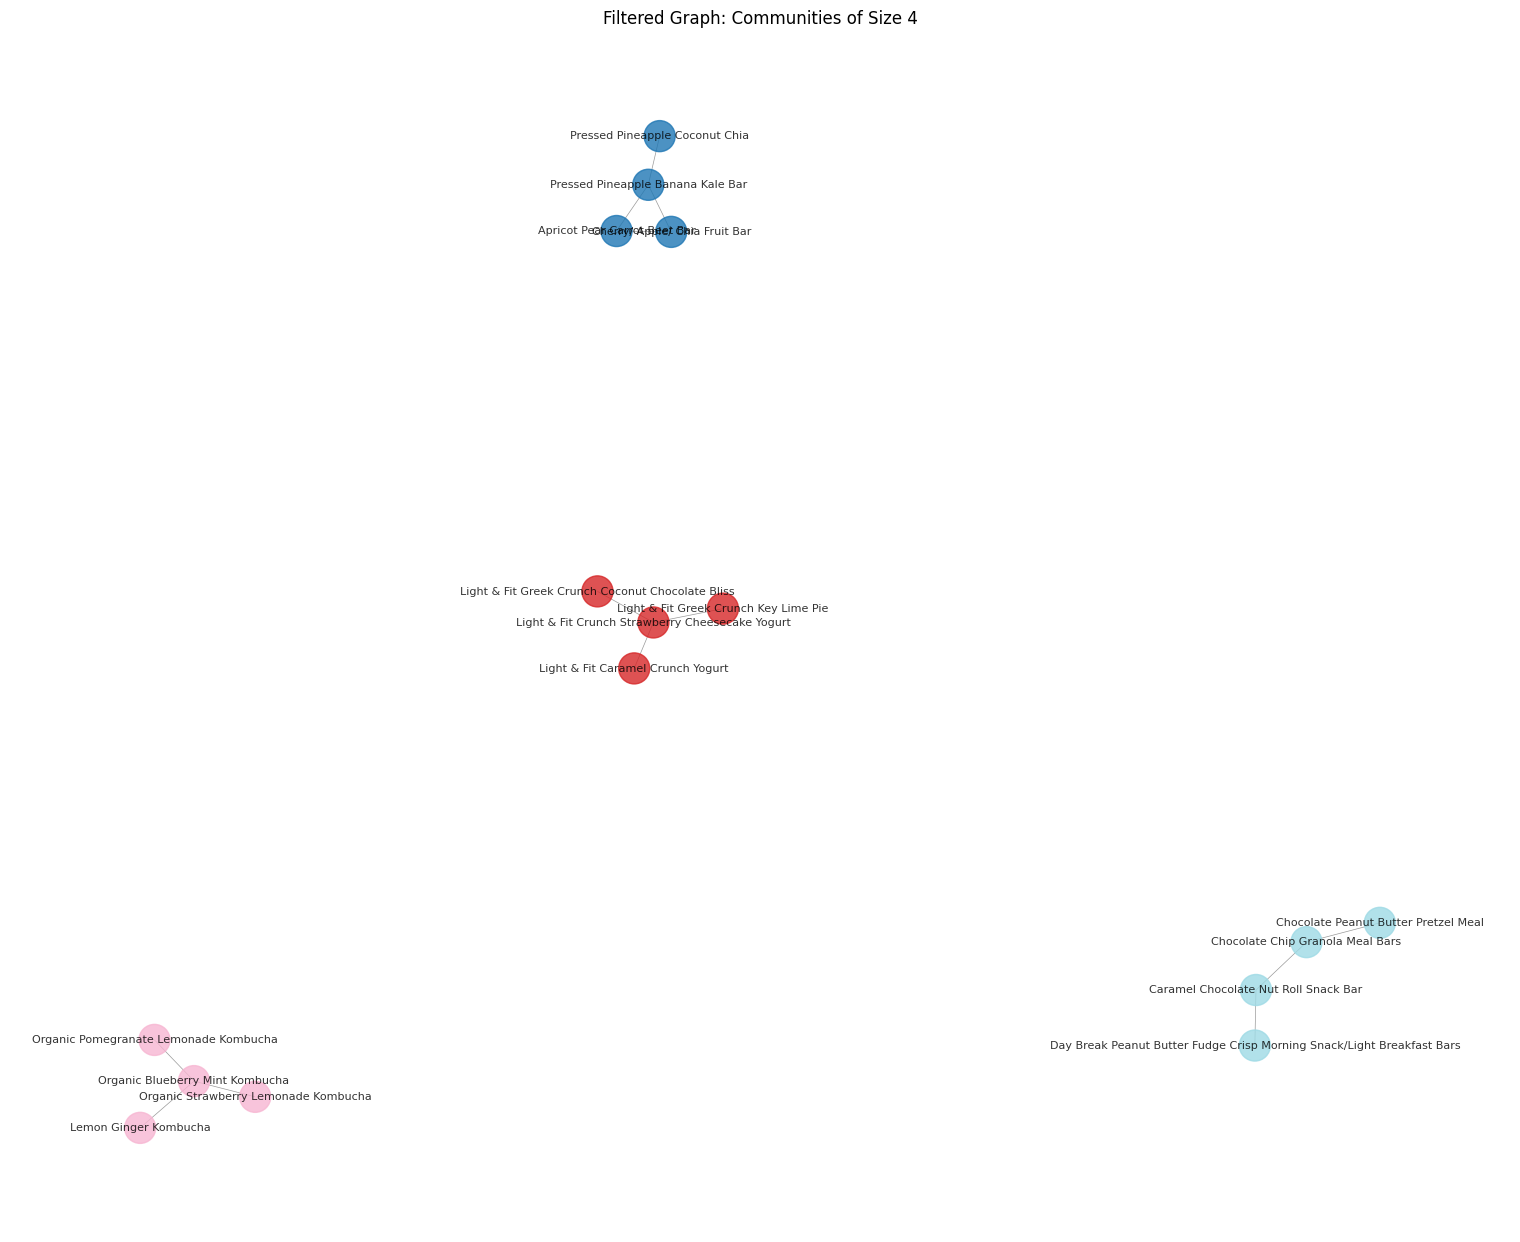

In [61]:
selected_communities = [comm for comm in mod_communities if len(comm) == 4]

# Step 3: Create a new graph with only the selected communities
# Combine all selected communities into a single list of nodes
selected_nodes = set(node for comm in selected_communities for node in comm)

# Create a subgraph that only includes the selected nodes
subgraph = filtered_pow_g.subgraph(selected_nodes)

# Assign community labels to the nodes in the subgraph (optional but useful for coloring)
for community_id, comm in enumerate(selected_communities):
    for node in comm:
        subgraph.nodes[node]['community'] = community_id

# Step 4: Assign colors to each community
community_colors = [subgraph.nodes[node]['community'] for node in subgraph.nodes()]

# Step 5: Choose a layout for the graph
pos = nx.spring_layout(subgraph, seed=42)  # You can experiment with different layouts

# Step 6: Create a color map (using a colormap to automatically assign distinct colors to communities)
cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories
node_color = [cmap(community_colors[i] / len(selected_communities)) for i in range(len(subgraph.nodes()))]

# Step 7: Plot the subgraph (filtered graph with selected communities)
plt.figure(figsize=(15, 12))
nx.draw(subgraph, pos, node_color=node_color, with_labels=True, font_size=8, node_size=500, edge_color='gray', width=0.5, alpha=0.8)
plt.title("Filtered Graph: Communities of Size 4")
plt.show()

/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_11466/1773862965.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories


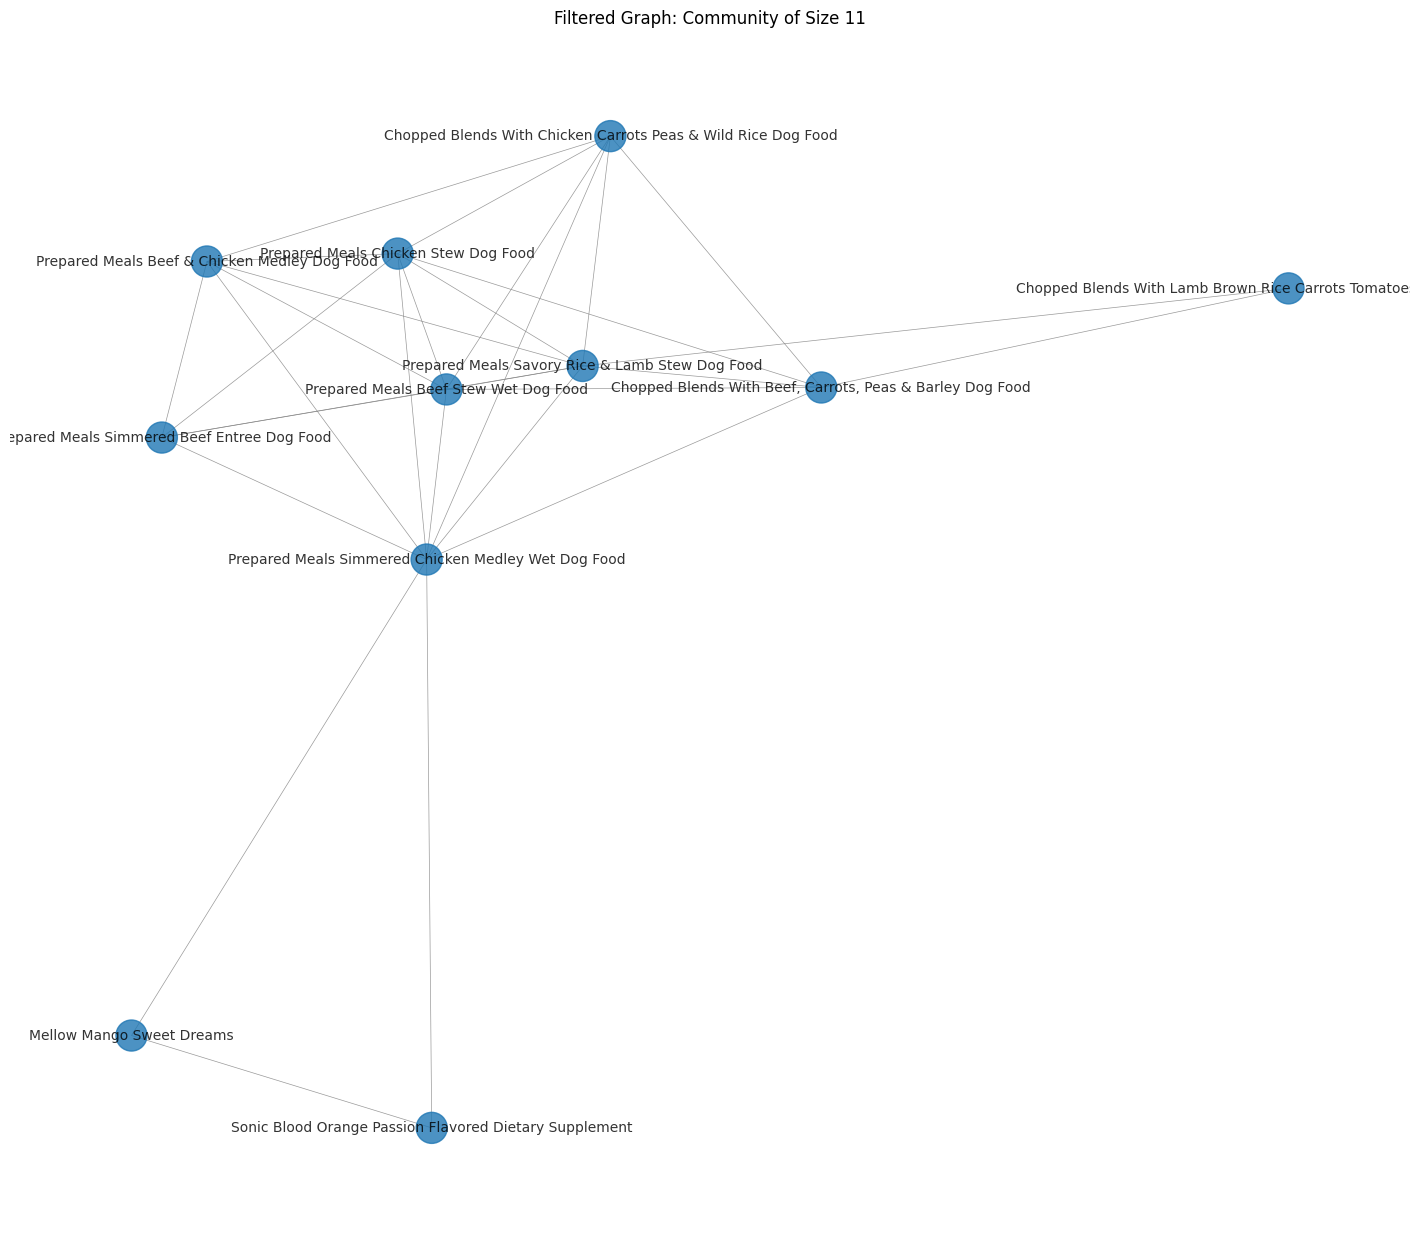

In [98]:
selected_communities = [comm for comm in mod_communities if len(comm) == 11]

# Step 3: Create a new graph with only the selected communities
# Combine all selected communities into a single list of nodes
selected_nodes = set(node for comm in selected_communities for node in comm)

# Create a subgraph that only includes the selected nodes
subgraph = filtered_pow_g.subgraph(selected_nodes)

# Assign community labels to the nodes in the subgraph (optional but useful for coloring)
for community_id, comm in enumerate(selected_communities):
    for node in comm:
        subgraph.nodes[node]['community'] = community_id

# Step 4: Assign colors to each community
community_colors = [subgraph.nodes[node]['community'] for node in subgraph.nodes()]

# Step 5: Choose a layout for the graph
pos = nx.spring_layout(subgraph, seed=42)  # You can experiment with different layouts

# Step 6: Create a color map (using a colormap to automatically assign distinct colors to communities)
cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories
node_color = [cmap(community_colors[i] / len(selected_communities)) for i in range(len(subgraph.nodes()))]

# Step 7: Plot the subgraph (filtered graph with selected communities)
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, node_color=node_color, with_labels=True, font_size=10, node_size=500, edge_color='gray', width=0.5, alpha=0.8)
plt.title("Filtered Graph: Community of Size 11")
_ = plt.show()

/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_11466/3657238548.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories


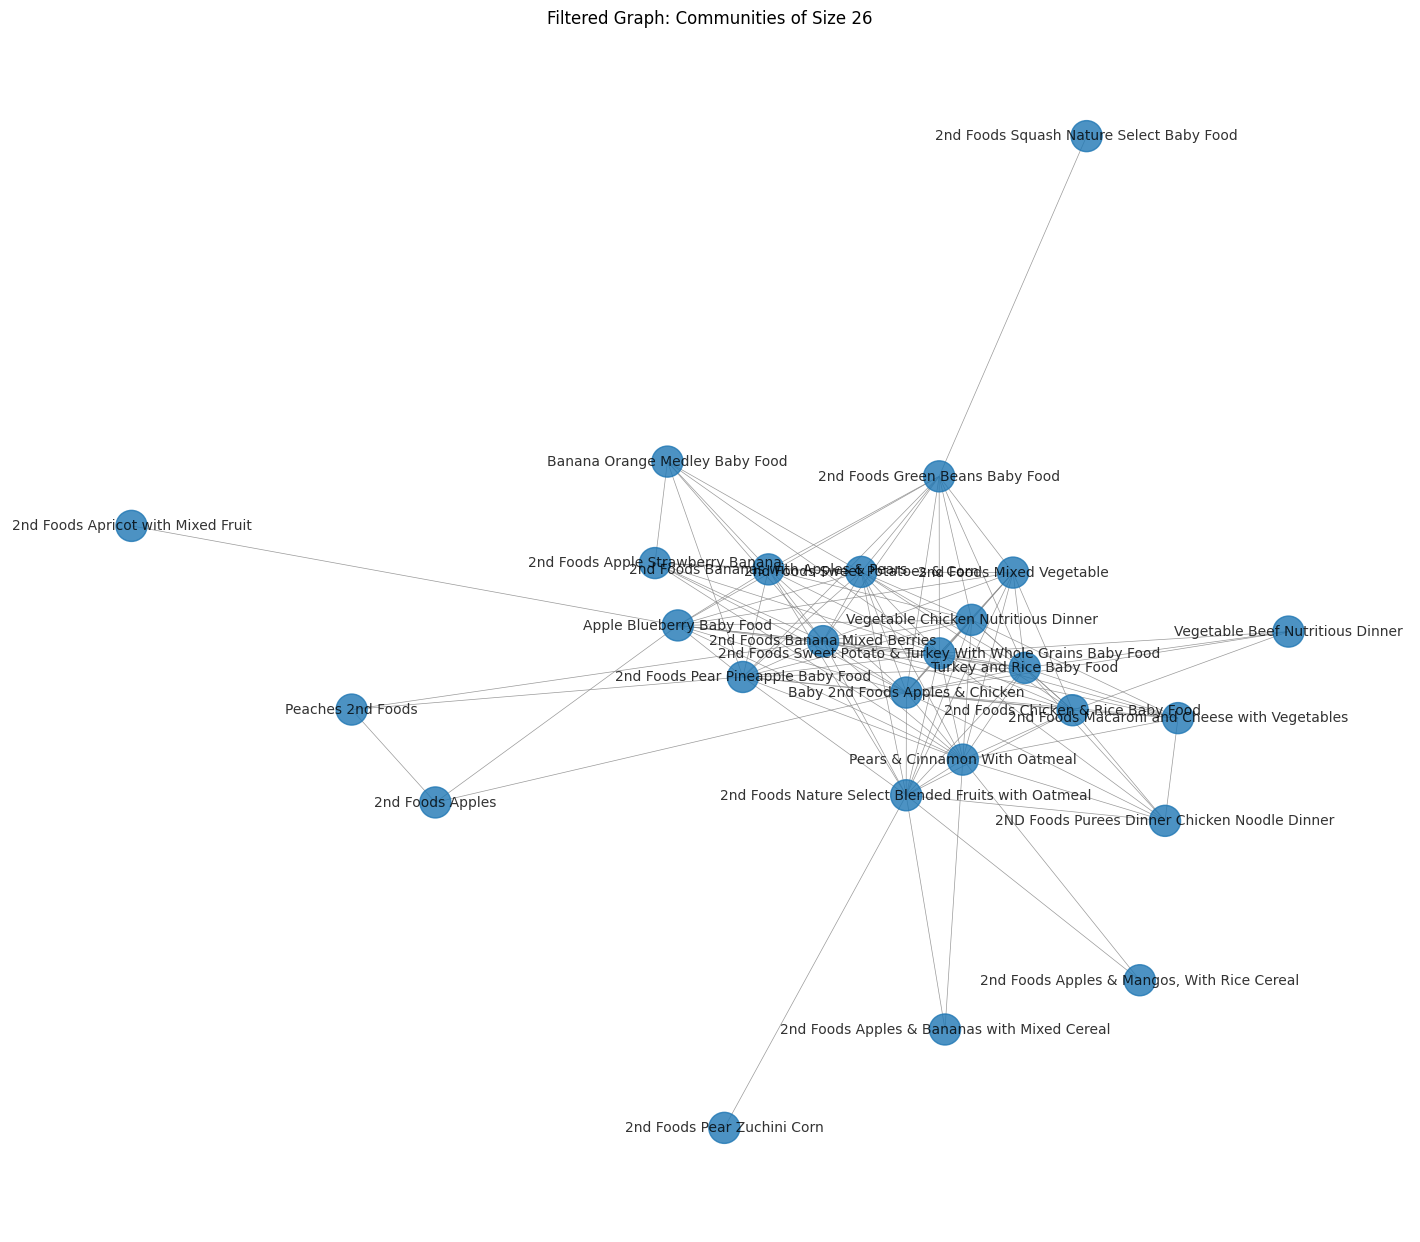

In [95]:
selected_communities = [comm for comm in mod_communities if len(comm) == 26]

# Step 3: Create a new graph with only the selected communities
# Combine all selected communities into a single list of nodes
selected_nodes = set(node for comm in selected_communities for node in comm)

# Create a subgraph that only includes the selected nodes
subgraph = filtered_pow_g.subgraph(selected_nodes)

# Assign community labels to the nodes in the subgraph (optional but useful for coloring)
for community_id, comm in enumerate(selected_communities):
    for node in comm:
        subgraph.nodes[node]['community'] = community_id

# Step 4: Assign colors to each community
community_colors = [subgraph.nodes[node]['community'] for node in subgraph.nodes()]

# Step 5: Choose a layout for the graph
pos = nx.spring_layout(subgraph, seed=42)  # You can experiment with different layouts

# Step 6: Create a color map (using a colormap to automatically assign distinct colors to communities)
cmap = plt.cm.get_cmap("tab20", len(selected_communities))  # 'tab20' is a good colormap for 20+ categories
node_color = [cmap(community_colors[i] / len(selected_communities)) for i in range(len(subgraph.nodes()))]

# Step 7: Plot the subgraph (filtered graph with selected communities)
plt.figure(figsize=(14, 12))
nx.draw(subgraph, pos, node_color=node_color, with_labels=True, font_size=10, node_size=500, edge_color='gray', width=0.5, alpha=0.8)
plt.title("Filtered Graph: Communities of Size 26")
_ = plt.show()

### Louvain

In [64]:

partition = community_louvain.best_partition(filtered_pow_g, weight='weight', random_state=42)
community_dict = {}
for node, community_id in partition.items():
    if community_id not in community_dict:
        community_dict[community_id] = []
    community_dict[community_id].append(node)

# Add community label as a node attribute
for community_id, nodes in community_dict.items():
    for node in nodes:
        if node in filtered_pow_g.nodes:  # Ensure the node exists in the graph
            filtered_pow_g.nodes[node]['community_louv'] = community_id

In [65]:
partition = pd.Series(partition)
partition.value_counts()
# report number of communities found
print("Number of communities detected:", len(partition.value_counts()))
# report the number of nodes in the largest community
print("Number of nodes in the largest community:", pd.DataFrame(partition.value_counts())['count'].max())

Number of communities detected: 111
Number of nodes in the largest community: 11461


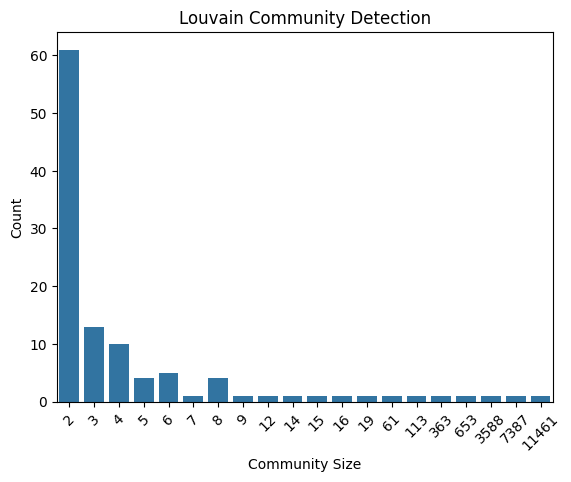

In [90]:
sns.countplot(x=partition.value_counts())
plt.xlabel('Community Size')
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=10)
plt.ylabel('Count')
_ = plt.title('Louvain Community Detection')

In [67]:
partition.value_counts().describe()

count     111.000
mean      216.225
std      1328.647
min         2.000
25%         2.000
50%         2.000
75%         4.000
max     11461.000
Name: count, dtype: float64

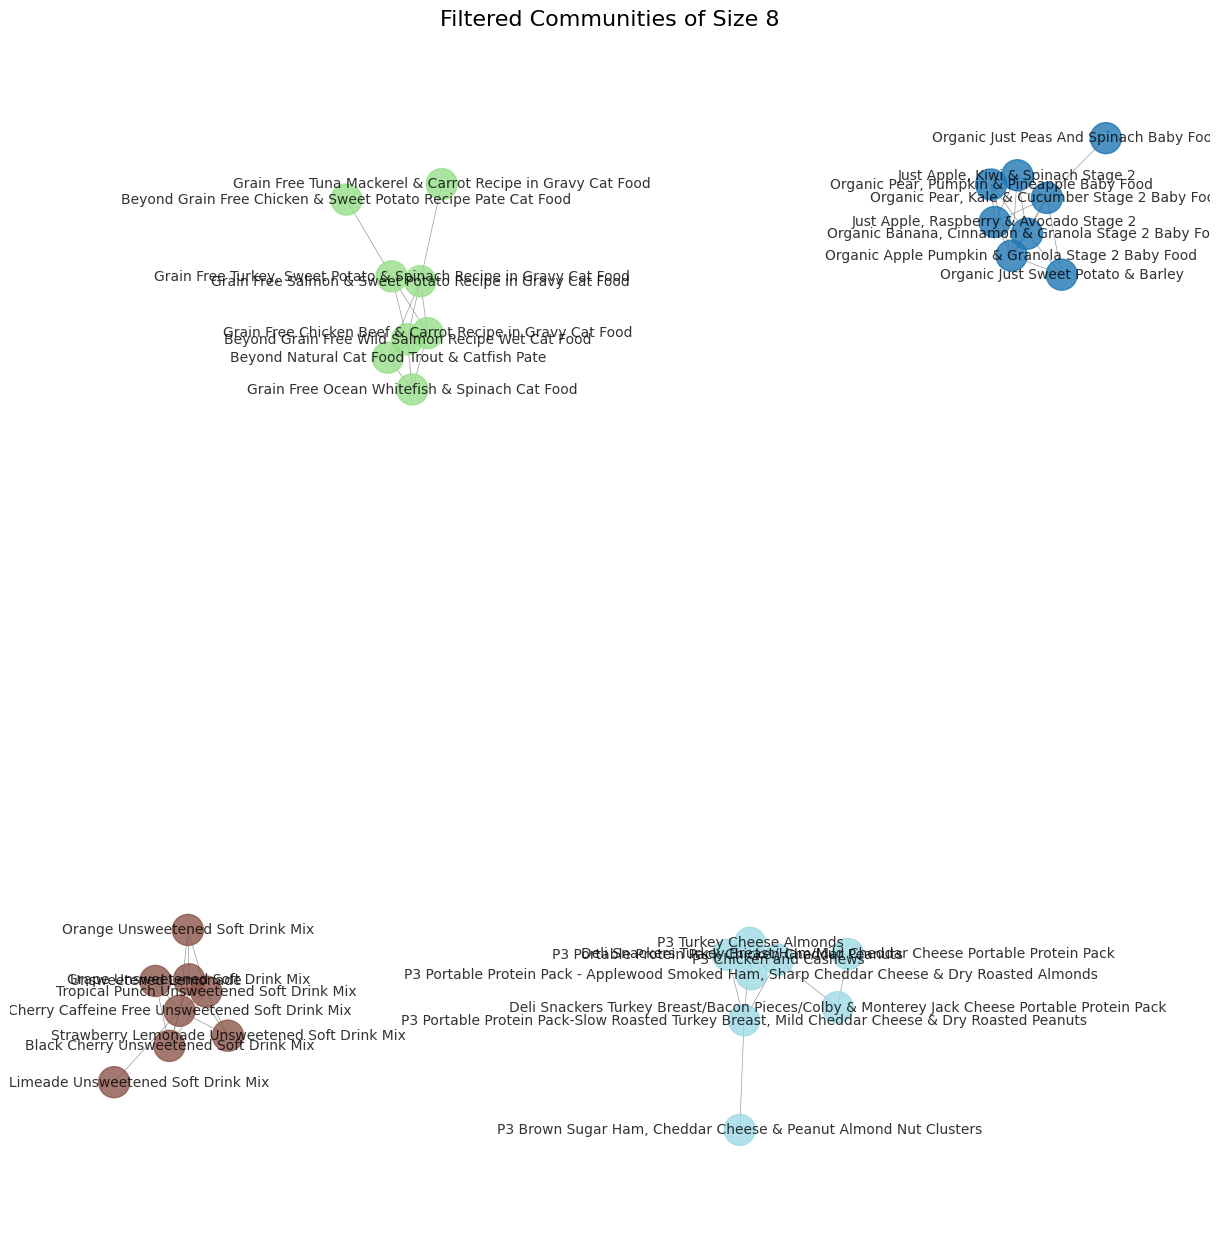

In [68]:
selected_communities = {community_id: nodes for community_id, nodes in community_dict.items() if len(nodes) == 8}

selected_nodes = [node for nodes in selected_communities.values() for node in nodes]
subgraph = filtered_pow_g.subgraph(selected_nodes)

for community_id, nodes in selected_communities.items():
    for node in nodes:
        if node in subgraph.nodes:  # Ensure the node exists in the subgraph
            subgraph.nodes[node]['community_louv'] = community_id


pos = nx.spring_layout(subgraph, seed=42, k=0.3) 

# Plot the graph
plt.figure(figsize=(12, 12))  # Increase figure size for clarity
node_color = [subgraph.nodes[node]['community_louv'] for node in subgraph.nodes()]  # Color by community

# Draw the graph
nx.draw(subgraph, pos, with_labels=True, node_color=node_color, cmap=plt.cm.tab20, node_size=500, font_size=10, edge_color='gray', width=0.5, alpha=0.8)

# Show the plot
plt.title("Filtered Communities of Size 8", fontsize=16)
plt.show()

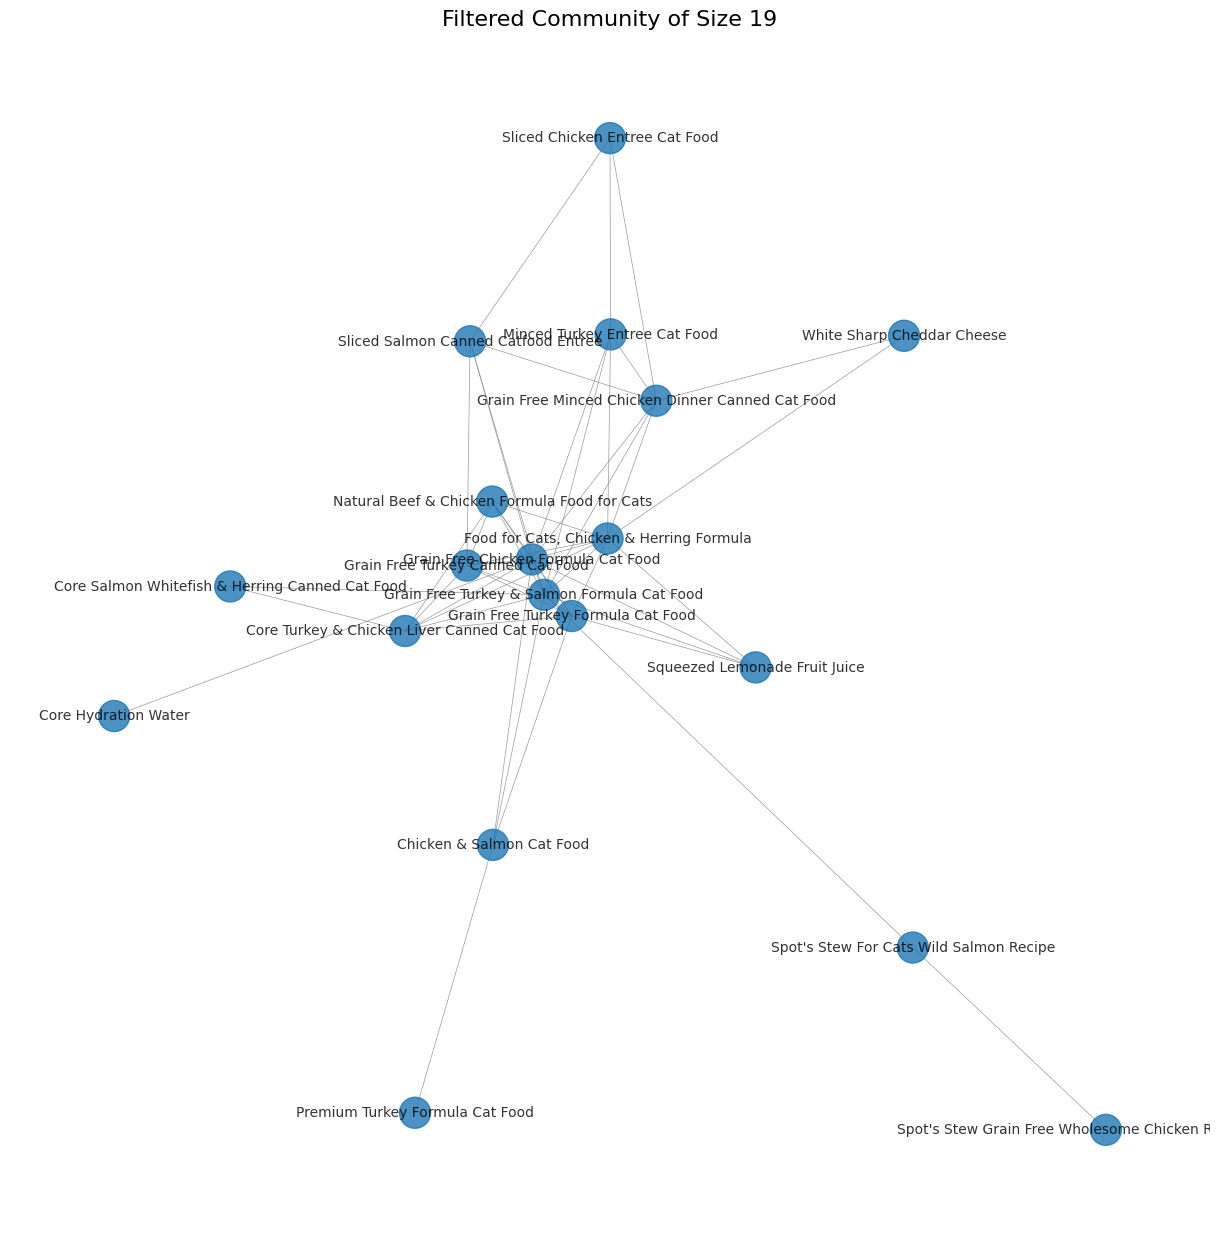

In [96]:
selected_communities = {community_id: nodes for community_id, nodes in community_dict.items() if len(nodes) == 19}

selected_nodes = [node for nodes in selected_communities.values() for node in nodes]
subgraph = filtered_pow_g.subgraph(selected_nodes)

for community_id, nodes in selected_communities.items():
    for node in nodes:
        if node in subgraph.nodes:  
            subgraph.nodes[node]['community_louv'] = community_id


pos = nx.spring_layout(subgraph, seed=42, k=0.3)  

plt.figure(figsize=(12, 12)) 
node_color = [subgraph.nodes[node]['community_louv'] for node in subgraph.nodes()]  


nx.draw(subgraph, pos, with_labels=True, node_color=node_color, cmap=plt.cm.tab20, node_size=500, font_size=10, edge_color='gray', width=0.5, alpha=0.8)


plt.title("Filtered Community of Size 19", fontsize=16)
plt.show()

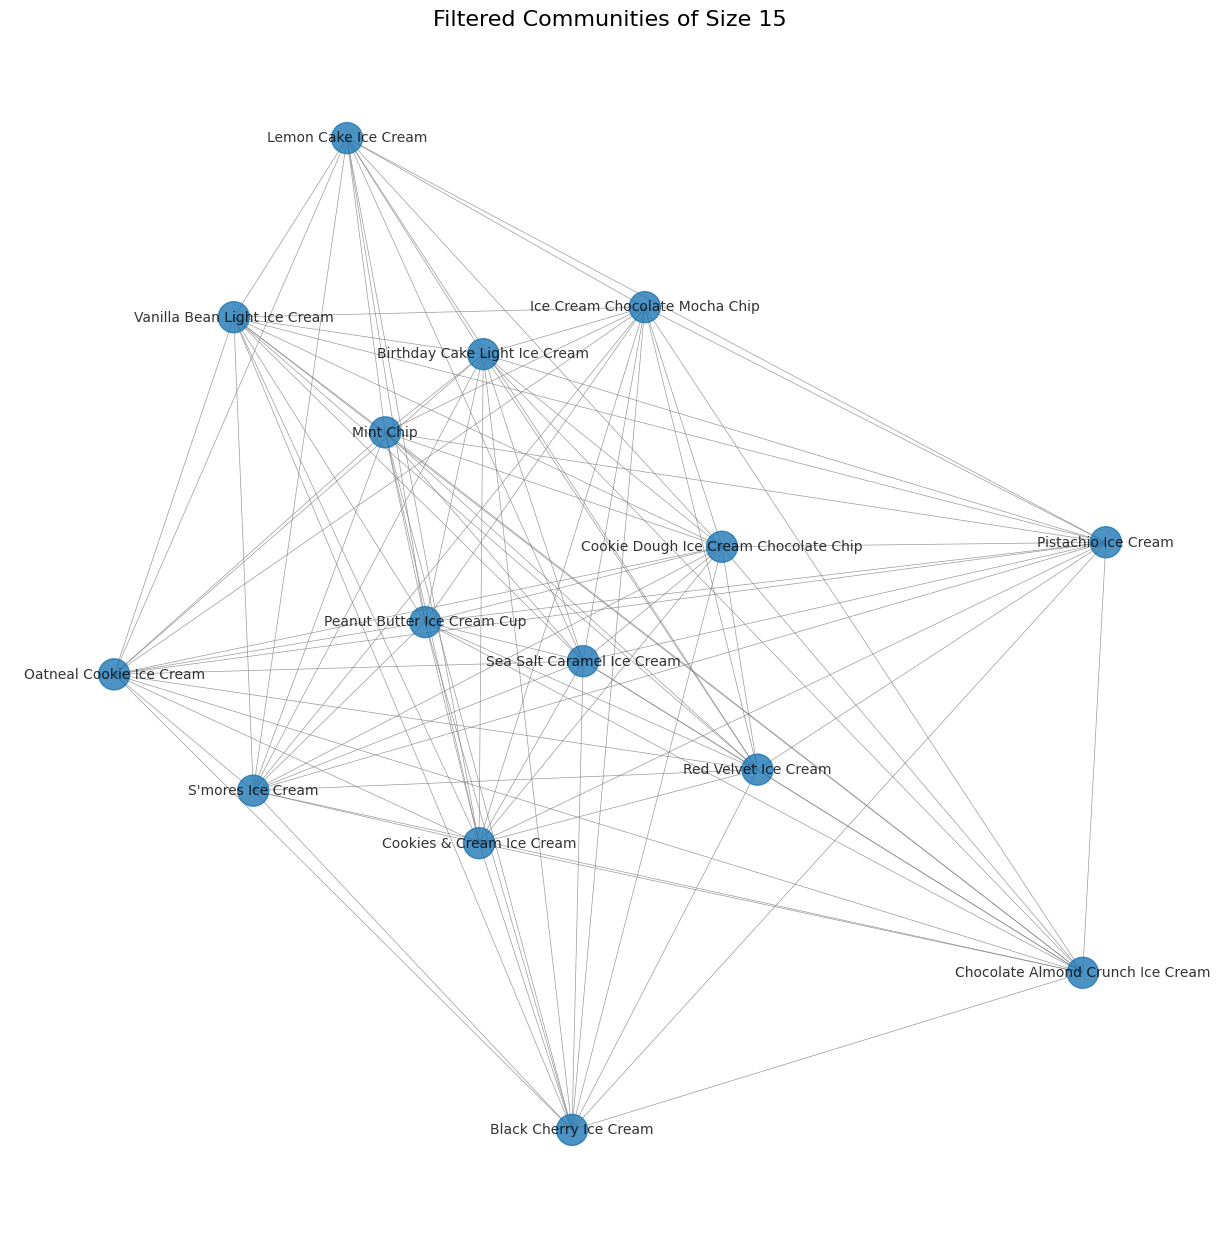

In [70]:
selected_communities = {community_id: nodes for community_id, nodes in community_dict.items() if len(nodes) == 15}

# Step 4: Create a subgraph with selected communities
selected_nodes = [node for nodes in selected_communities.values() for node in nodes]
subgraph = filtered_pow_g.subgraph(selected_nodes)

# Step 5: Add community labels to nodes in the subgraph (optional)
for community_id, nodes in selected_communities.items():
    for node in nodes:
        if node in subgraph.nodes:  # Ensure the node exists in the subgraph
            subgraph.nodes[node]['community_louv'] = community_id

# Step 6: Layout and plot the graph
# Using spring_layout or another layout method to position nodes
pos = nx.spring_layout(subgraph, seed=42, k=0.3)  # Adjust 'k' for better spacing

# Plot the graph
plt.figure(figsize=(12, 12))  # Increase figure size for clarity
node_color = [subgraph.nodes[node]['community_louv'] for node in subgraph.nodes()]  # Color by community

# Draw the graph
nx.draw(subgraph, pos, with_labels=True, node_color=node_color, cmap=plt.cm.tab20, node_size=500, font_size=10, edge_color='gray', width=0.5, alpha=0.8)

# Show the plot
plt.title("Filtered Communities of Size 15", fontsize=16)
plt.show()

## RECOMMENDATION

### Collaborative Filtering

In [71]:

# Function to create adjacency matrix
def create_co_purchase_matrix(graph):
    product_list = list(graph.nodes)
    product_index = {product: i for i, product in enumerate(product_list)}
    
    co_purchase_matrix = np.zeros((len(product_list), len(product_list)))
    
    for u, v, data in graph.edges(data=True):
        i, j = product_index[u], product_index[v]
        co_purchase_matrix[i, j] = data['weight']
        co_purchase_matrix[j, i] = data['weight']  
    
    return co_purchase_matrix, product_list

co_purchase_matrix, product_list = create_co_purchase_matrix(filtered_pow_g)

svd = TruncatedSVD(n_components=50, random_state=42)
reduced_matrix = svd.fit_transform(co_purchase_matrix)


node_data = [(node, filtered_pow_g.nodes[node]['aisle_id'], filtered_pow_g.nodes[node]['department_number'],\
               filtered_pow_g.nodes[node]['community'], filtered_pow_g.nodes[node]['community_louv']) for node in filtered_pow_g.nodes()]

product_attributes = pd.DataFrame(node_data, columns=['product_name', 'aisle_id', 'department_number', 'community', 'community_louv'])


aisle_ids = product_attributes['aisle_id'].values
department_numbers = product_attributes['department_number'].values
community_greed = product_attributes['community'].values
community_louvs = product_attributes['community_louv'].values

cosine_sim_df = pd.DataFrame(cosine_similarity(reduced_matrix), index=product_attributes['product_name'], columns=product_attributes['product_name'])

# Function to boost similarity score for shared product attributes
def add_aisle_bonus_optimized(cosine_sim_df, product_attributes, bonus=2.5):
    similarity_matrix = cosine_sim_df.values
    
    aisle_ids = product_attributes['aisle_id'].values
    department_numbers = product_attributes['department_number'].values
    community_greed = product_attributes['community'].values
    community_louvs = product_attributes['community_louv'].values
    
    aisle_comparison = (aisle_ids[:, None] == aisle_ids)
    department_comparison = (department_numbers[:, None] == department_numbers)
    community_greed_comparison = (community_greed[:, None] == community_greed )
    community_louv_comparison = (community_louvs[:, None] == community_louvs)

    similarity_matrix[aisle_comparison & ~np.eye(len(aisle_ids), dtype=bool)] += bonus
    similarity_matrix[department_comparison & ~np.eye(len(department_numbers), dtype=bool)] += bonus
    similarity_matrix[community_greed_comparison & ~np.eye(len(community_greed), dtype=bool)] += bonus
    similarity_matrix[community_louv_comparison & ~np.eye(len(community_louvs), dtype=bool)] += bonus

    cosine_sim_df = pd.DataFrame(similarity_matrix, index=cosine_sim_df.index, columns=cosine_sim_df.columns)
    
    return cosine_sim_df

cosine_sim_df = add_aisle_bonus_optimized(cosine_sim_df, product_attributes)

# Function to recommend/identify missing product based on collaborative filtering
def recommend_next_product(basket, cosine_sim_df, top_n=5):
    sim_scores = defaultdict(float)
    
    for product in basket:
        if product not in product_list:
            continue
        for other_product in cosine_sim_df[product].index:
            if other_product not in basket:  
                sim_scores[other_product] += cosine_sim_df[product][other_product]
    
    sorted_sim_scores = sorted(sim_scores.items(), key=lambda x: x[1], reverse=True)
    
    recommended_products = [product for product, _ in sorted_sim_scores[:top_n]]
    return recommended_products


In [72]:
print("Sparsity of the co-purchase matrix: ", np.sum(create_co_purchase_matrix(filtered_pow_g)[0] == 0) / create_co_purchase_matrix(filtered_pow_g)[0].size)


Sparsity of the co-purchase matrix:  0.9921866372382394


In [92]:
# Example usage
basket = ['Large Alfresco Eggs',
   'Large Grapefruit',
   'Ripe Large Pitted Olives',
   'Moroccan Mint Green Tea']
recommended_products = recommend_next_product(basket, cosine_sim_df, top_n=15)
print(recommended_products)

['Organic Kosher Dill Pickles', 'Organic Extra Large Brown Eggs', 'Organic Grade A Free Range Large Brown Eggs', 'Organic Braeburn Apple', 'Bread & Butter Pickle Chips', 'Just Green Unsweetened Tea', 'Organic Egg Whites', 'Blood Oranges', 'Tommy/Kent/Keitt/Haden Mango', 'Grape White/Green Seedless', 'Organic Red Delicious Apple', 'Sliced Black Olives', 'Cantaloupe', 'Organic Green Tea Bags', 'Brown Eggs']


In [74]:
random.seed(42)
# Function to split orders and randomly remove one product per order
def create_train_test_split(train_data):
    splits = []
    for _, order_group in train_data.groupby('order_id'):
        products = order_group['product_name'].tolist()
        # Randomly remove one product from the order
        if len(products) > 1:
            test_product = random.choice(products)
            train_set = [p for p in products if p != test_product]
            splits.append((train_set, test_product))
    return random.sample(splits, k=1000)

train_test_splits = create_train_test_split(full_order_train)

In [75]:
train_test_splits

[(['Granny Smith Apples',
   'Flax Plus Organic Pumpkin Flax Granola',
   'No Pulp Calcium & Vitamin D Pure Orange Juice',
   'Squeeze Tomato Ketchup',
   'G Series Perform Lemon Lime Sports Drink',
   'Milk',
   'Milk Chocolate with Whole Hazelnuts',
   'Cold Activated Beer',
   'Sugar Free Bubble Gum Value Pack'],
  'Cabernet Sauvignon'),
 (['Cabernet Sauvignon', 'Monterey Pinot Gris', 'Pinot Gris'],
  'Handmade Vodka'),
 (['Large Alfresco Eggs',
   'Large Grapefruit',
   'Ripe Large Pitted Olives',
   'Moroccan Mint Green Tea'],
  'Original Whole Fat Lactose Free Milk'),
 (['Organic Baby Arugula',
   'Organic Avocado',
   'Total 0% Nonfat Greek Yogurt',
   'Sustainably Soft Bath Tissue',
   'Feta Cheese Crumbles',
   'Organic Romaine',
   '100% Recycled Paper Towels',
   'Organic Unsweetened Vanilla Almond Milk',
   'Organic Original Almond Milk',
   'Organic Milk Chocolate Peanut Butter Cups',
   'Vegan Peanut Butter Chocolate Chip Cookies',
   'Alkaline Water',
   'Pain Relieving 

In [76]:
# Function to evaluate the recommendation system on the train-test splits
def evaluate_recommendations(train_test_splits, cosine_sim_df, top_n=5):
    precision_list = []

    for train_set, test_product in train_test_splits:
        recommended_products = recommend_next_product(train_set, cosine_sim_df, top_n)
        if test_product in recommended_products:
            precision_list.append(1)
        else:
            precision_list.append(0)

    precision = sum(precision_list) / len(precision_list)
    return precision

precision = evaluate_recommendations(train_test_splits, cosine_sim_df, top_n=15)

print(f'Precision: {precision:.4f}')


Precision: 0.0360


## APRIORI

In [77]:
# memory constraint
full_order_prior_ap=full_order_prior[full_order_prior['order_id']<=10000]

In [78]:
items=full_order_prior_ap[['order_id','product_name']].copy()

In [79]:
items.rename(columns={'order_id':'order','product_name':'items'},inplace=True)
items['temp']=1

In [80]:
df = items.groupby(['order','items'])['temp'].sum().unstack().fillna(0)

In [81]:
freq_itemsets = apriori(df,min_support=0.01,use_colnames=True)
freq_itemsets

/Users/kileyprice/Library/CloudStorage/OneDrive-Umich/SI 608/.venv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.012,(100% Raw Coconut Water)
1,0.018,(100% Whole Wheat Bread)
2,0.012,(2% Reduced Fat Milk)
3,0.027,(Apple Honeycrisp Organic)
4,0.019,(Asparagus)
...,...,...
110,0.019,"(Banana, Organic Strawberries)"
111,0.014,"(Banana, Strawberries)"
112,0.013,"(Organic Strawberries, Organic Baby Spinach)"
113,0.012,"(Organic Strawberries, Organic Hass Avocado)"


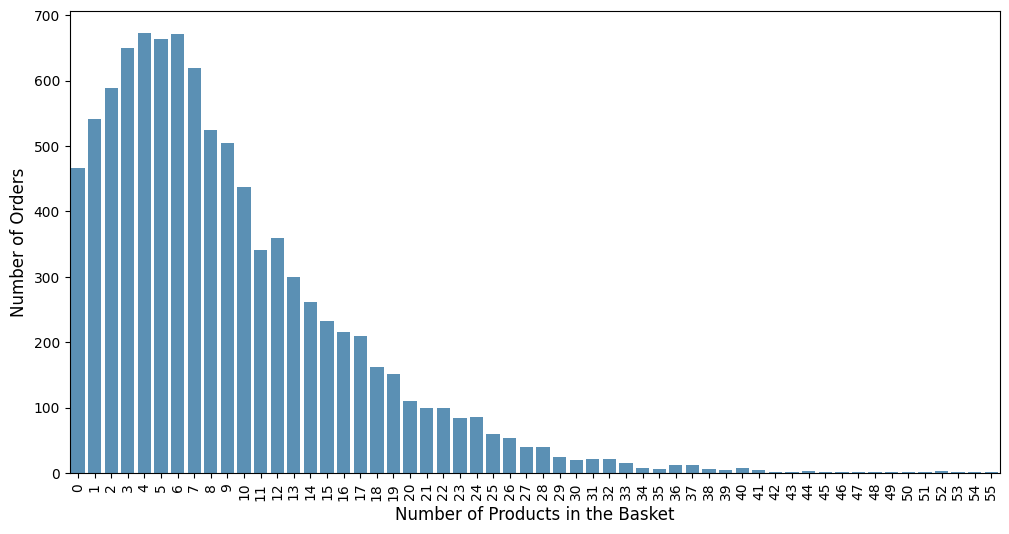

In [82]:
#basket size visualization
basket_size = df.sum(axis=1).value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.barplot( basket_size.values, alpha=0.8)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Number of Products in the Basket', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [83]:
def make_matrix(df):
        return df.groupby(['order','items'])['temp'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

df_matrix = make_matrix(items)

req_itemsets = apriori(df_matrix, min_support=0.01, use_colnames=True)

# Collecting the inferred rules in a dataframe 
rules = association_rules(freq_itemsets,metric='support',min_threshold=0.01)
rules.sort_values('support',ascending=False)

/var/folders/c5/pfcqzhrn7w15jg9w7c0n08b40000gn/T/ipykernel_11466/2846155778.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x > 0 else 0)
/Users/kileyprice/Library/CloudStorage/OneDrive-Umich/SI 608/.venv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.065,0.121,0.019,0.298,2.468,0.011,1.252,0.636
3,(Bag of Organic Bananas),(Organic Hass Avocado),0.121,0.065,0.019,0.160,2.468,0.011,1.113,0.676
19,(Organic Strawberries),(Banana),0.079,0.149,0.019,0.234,1.569,0.007,1.111,0.394
18,(Banana),(Organic Strawberries),0.149,0.079,0.019,0.124,1.569,0.007,1.052,0.426
6,(Organic Strawberries),(Bag of Organic Bananas),0.079,0.121,0.017,0.217,1.794,0.008,1.122,0.481
7,(Bag of Organic Bananas),(Organic Strawberries),0.121,0.079,0.017,0.142,1.794,0.008,1.073,0.504
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.073,0.121,0.016,0.217,1.800,0.007,1.123,0.479
1,(Bag of Organic Bananas),(Organic Baby Spinach),0.121,0.073,0.016,0.131,1.800,0.007,1.067,0.505
10,(Banana),(Organic Avocado),0.149,0.056,0.016,0.105,1.881,0.007,1.055,0.551
11,(Organic Avocado),(Banana),0.056,0.149,0.016,0.281,1.881,0.007,1.183,0.496


In [84]:
filtered_rules = rules[(rules['antecedent support'] > 0.02)&
                        (rules['consequent support'] >0.01) &
                        (rules['confidence'] > 0.45) &
                        (rules['lift'] > 1.0)&
                        (rules['support']>0.195)]

In [85]:
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent:list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent:list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

In [86]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

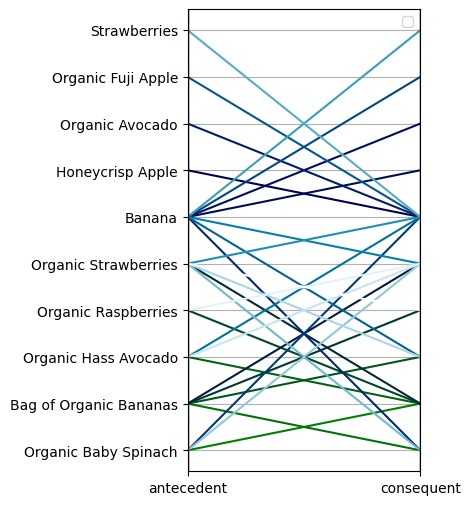

In [87]:
coords = rules_to_coordinates(rules)
# Generate parallel coordinates plot
plt.figure(figsize=(3,6))
parallel_coordinates(coords, 'rule',colormap = 'ocean')
plt.legend([])
plt.show()